# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

To allow for long-running processes (i.e. network training) import [workspace_utils](https://github.com/udacity/workspaces-student-support/tree/master/jupyter). Using magic command %load to import into next cell.

In [2]:
import os
project_dir = "/home/workspace/"
os.path.isfile(project_dir + "workspace_utils.py")

True

In [3]:
# %load workspace_utils.py
import signal
 
from contextlib import contextmanager
 
import requests
 
 
DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}
 
 
def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler
 
 
@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:
 
    from workspace_utils import active_session
 
    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)
 
 
def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:
 
    from workspace_utils import keep_awake
 
    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable


In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [5]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

## [Explore](#dataExplore) data in more depth, and [export refined version](#dataRefine) 
- **See Appendix, where after data exploration, very short and unintelligible entries are removed**
- **Then, data is saved in alternative Seinfeld_Scripts_cleaned.txt**

<a id='word2vec'></a>

# Set up a word2vec lookup so we can use pre-trained weights later
- https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
- using the Glove 6B 300 embeddings set
- allow for previously running the code and saving the weights matrix as weights_matrix.pkl, in which case we can bypass this

In [6]:
weights_matrix = []
glove_path = '../../data/glove6B'
weights_file = 'weights_matrix.pkl'
use_word2vec = False

In [7]:
import os
import numpy as np
import pickle
if os.path.isfile(f'{weights_file}'):
    weights_matrix = pickle.load(open(f'weights_matrix.pkl', 'rb'))
    use_word2vec = True
    
use_word2vec

True

**Next step should not be required as we load the pre-built weights above from a pickle file**

In [8]:
if not use_word2vec:
    glove_file = os.path.join(f'{glove_path}/glove.6B.300d.txt')
    use_word2vec = (os.path.isfile(glove_file))

use_word2vec

True

In [9]:
use_word2vec and len(weights_matrix) > 0

True

In [10]:
use_word2vec and os.path.isfile(f'{glove_path}/6B.300_words.pkl')

False

**If running creation of word2vec vectors below bcolz will be required, however we bypass this by loading pre-built weights above**
- **Therefore, do not run the next 3 cells...**

In [11]:
!conda install -c conda-forge bcolz

In [12]:
if use_word2vec and len(weights_matrix) == 0 and not os.path.isfile(f'{glove_path}/6B.300_words.pkl'):
    import bcolz
    import numpy as np
    import pickle    

    w2v_words = []
    idx = 0
    w2v_word2idx = {}
    w2v_vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.300.dat', mode='w')

    with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            w2v_words.append(word)
            w2v_word2idx[word] = idx
            idx += 1
            vect = np.array(line[1:]).astype(np.float)
            w2v_vectors.append(vect)

    w2v_vectors = bcolz.carray(w2v_vectors[1:].reshape((400000, 300)), rootdir=f'{glove_path}/6B.300.dat', mode='w')
    w2v_vectors.flush()
    pickle.dump(w2v_words, open(f'{glove_path}/6B.300_words.pkl', 'wb'))
    pickle.dump(w2v_word2idx, open(f'{glove_path}/6B.300_idx.pkl', 'wb'))

In [13]:
if use_word2vec and len(weights_matrix) == 0 :
    import bcolz
    import pickle

    w2v_vectors = bcolz.open(f'{glove_path}/6B.300.dat')[:]
    w2v_words = pickle.load(open(f'{glove_path}/6B.300_words.pkl', 'rb'))
    w2v_word2idx = pickle.load(open(f'{glove_path}/6B.300_idx.pkl', 'rb'))

    glove = {w: w2v_vectors[w2v_word2idx[w]] for w in w2v_words}

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [14]:
from collections import Counter
import problem_unittests as tests

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement Function
    if type(text) == str:
        text = text.split()
    word_counts = Counter(text)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    
    return vocab_to_int, int_to_vocab  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [15]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    token_dict = {
        '.'   : '||period||',
        ','   : '||comma||',
        '"'   : '||quotation_mark||',
        ';'   : '||semi_colon||',
        '!'   : '||exclamation_mark||',
        '?'   : '||question_mark||',
        '('   : '||left_parentheses||',
        ')'   : '||right_parentheses||',
        '-'   : '||dash||',
        '\n'  : '||return||'
    }    
    
    return token_dict
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Replace data_dir with previously exported Seinfeld_Scripts_cleaned.txt 
- Using `Seinfeld_Scripts_cleaned.txt` ensures that preprocess_and_save_data will replace the standard preprocess.p with one that has very short and unintelligible entries removed
- See [Export Refined Data](#dataRefine)

In [16]:
if os.path.isfile('./data/Seinfeld_Scripts_cleaned.txt'):
    data_dir = './data/Seinfeld_Scripts_cleaned.txt'
    text = helper.load_data(data_dir)

In [17]:
data_dir

'./data/Seinfeld_Scripts_cleaned.txt'

<a id='preprocess_save'></a>

## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [21]:
device = torch.device("cuda" if train_on_gpu else "cpu")  

In [22]:
device

device(type='cuda')

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

## Adapted from Udacity knowledge base [code](https://knowledge.udacity.com/questions/29798) ~ Survesh C

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def batch_data(words, sequence_length, batch_size, padbatch=False):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    
    # keep only enough words to make full sequences, so adjust to 5 from end
    dwords = words[:-sequence_length]
    arr_len = len(dwords)
    
    # if the adjusted length is greater than zero then process further, otherwise deal with it later
    if arr_len > 0:
        feature_tensors = []
        target_tensors = []

        # iterate through the array, one sequence at a time
        for n in range(0, len(dwords)):
            feature_tensors.append(words[n:n+sequence_length])
            target_tensors.append(words[n+sequence_length])
            
        # convert the arrays to numpy arrays before further processing
        feature_tensors = np.array(feature_tensors) 
        target_tensors = np.array(target_tensors)

        # get the number of whole batches
        num_batches = len(dwords)//batch_size
        
        # check total array size, for comparison with whole batch size
        arr_len = len(feature_tensors)

    # arrange for arrays to be padded with zeros to return whole batches...
    if (arr_len <= 0) or (arr_len < batch_size and padbatch==False):
        # nothing at all to process, just return all zeros - ignore padbatch setting
        feature_tensors = np.zeros((batch_size, sequence_length))
        target_tensors  = np.zeros(batch_size)
    elif arr_len < batch_size and padbatch==True:
        # the incoming data exists, but is not enough for one batch, pad the batch with zero
        feature_tensors = np.pad(feature_tensors, [(0, batch_size - arr_len), (0, 0)], mode='constant')
        target_tensors  = np.pad(target_tensors,  [(0, batch_size - arr_len)], mode='constant')        
    elif num_batches*batch_size < arr_len and padbatch==True:
        # when possible whole batches are removed we have a few record remaining, pad the last batch with zero
        feature_tensors = np.pad(feature_tensors, [(0, arr_len - num_batches*batch_size), (0, 0)], mode='constant')
        target_tensors  = np.pad(target_tensors,  [(0, arr_len - num_batches*batch_size)], mode='constant')
    else:
        # everything is balanced, not strictly required as we have all complete batches already
        feature_tensors = feature_tensors[:num_batches*batch_size]
        target_tensors = target_tensors[:num_batches*batch_size]
        
    # convert to torch tensors
    torch_features = torch.from_numpy(feature_tensors).long()
    torch_targets = torch.from_numpy(target_tensors).long()
    
    # create a TensorDataset and then a DataLoader
    data = TensorDataset(torch_features, torch_targets)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return data_loader

### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

## Test with no padbatch parameter, default is False

In [24]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[14, 15, 16, 17, 18],
        [16, 17, 18, 19, 20],
        [ 7,  8,  9, 10, 11],
        [ 4,  5,  6,  7,  8],
        [17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6],
        [ 1,  2,  3,  4,  5],
        [23, 24, 25, 26, 27],
        [ 6,  7,  8,  9, 10],
        [26, 27, 28, 29, 30]])

torch.Size([10])
tensor([19, 21, 12,  9, 22,  7,  6, 28, 11, 31])


With padbatch False, the maximum combination is `[39, 40, 41, 42, 43],[44]` 

In [25]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[32, 33, 34, 35, 36],
        [15, 16, 17, 18, 19],
        [ 0,  1,  2,  3,  4],
        [ 6,  7,  8,  9, 10],
        [34, 35, 36, 37, 38],
        [20, 21, 22, 23, 24],
        [ 8,  9, 10, 11, 12],
        [ 9, 10, 11, 12, 13],
        [39, 40, 41, 42, 43],
        [33, 34, 35, 36, 37]])

torch.Size([10])
tensor([37, 20,  5, 11, 39, 25, 13, 14, 44, 38])


### Test dataloader with padbatch=True
- Maximum combination is `[44, 45, 46, 47, 48],[49]` which is the entire range

In [26]:
test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[42, 43, 44, 45, 46],
        [22, 23, 24, 25, 26],
        [29, 30, 31, 32, 33],
        [20, 21, 22, 23, 24],
        [16, 17, 18, 19, 20],
        [ 8,  9, 10, 11, 12],
        [28, 29, 30, 31, 32],
        [14, 15, 16, 17, 18],
        [31, 32, 33, 34, 35],
        [44, 45, 46, 47, 48]])

torch.Size([10])
tensor([47, 27, 34, 25, 21, 13, 33, 19, 36, 49])


## Dataloader with padbatch=True will also load minimal examples...

In [27]:
test_text = [15,16,17,18,19,20]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 0,  0,  0,  0,  0],
        [15, 16, 17, 18, 19],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])

torch.Size([10])
tensor([ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0])


---
## Load word2vec vectors into a weights array if applicable
- **That is, if using word2vec but weights array has not been pre-loaded above...**

In [28]:
import pickle
import numpy as np

if use_word2vec and len(weights_matrix) == 0:
    weights_matrix = []
    words_found = 0
    emb_dim = 300

    matrix_len = len(vocab_to_int)
    weights_matrix = np.zeros((matrix_len, emb_dim))

    for i, word in enumerate(vocab_to_int):
        try: 
            weights_matrix[i] = glove[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
            
    pickle.dump(weights_matrix, open(f'weights_matrix.pkl', 'wb'))

In [29]:
if len(weights_matrix) > 0:
    weights_matrix = torch.FloatTensor(weights_matrix)

### If `weights_array` has same length as vocab and is a dimension of 300 it can be used...

In [30]:
use_word2vec, len(vocab_to_int), len(weights_matrix), len(weights_matrix[0])

(True, 21380, 21380, 300)

---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [31]:
%%time

import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5, 
                 droplayer_dropout=0.3,
                 use_word2vec=True,
                 rnnType='LSTM'
                 # , weightDrop=0, tieWeights=False ## placeholder - might experiment with weight dropout, weight tieing
                 ):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        
        # TODO: Implement function
        
        # set class variables
        self.vocab_size = vocab_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_word2vec = use_word2vec
        self.rnnType = rnnType
        
        # Set dropout layer to a separate value to passed dropout used by the LSTM 
        self.droplayer_dropout = droplayer_dropout # self.dropout # 0.3
        
        # define model layers
        
        # Embedding layer - use pre-trained word2vec if use_word2vec is True 
        # and we've been asked for a 300 dimension embedding
        # and the weights matrix fits our vocabulary size
        if use_word2vec and self.embedding_dim==300 and len(weights_matrix) == len(vocab_to_int):
            self.word_embeddings = nn.Embedding.from_pretrained(weights_matrix)
        else:    
            self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # use an LSTM or GRU
        if self.rnnType=='LSTM':
            self.rnn = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers,
                               dropout=self.dropout, batch_first=True) 
        else:
            self.rnn = nn.GRU(self.embedding_dim, self.hidden_dim, self.n_layers,
                              dropout=self.dropout, batch_first=True)
            
        # Dropout
        # self.dropout_layer = nn.Dropout(self.droplayer_dropout)
        
        # Output Linear layer
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """

        # TODO: Implement function 
        batch_size = nn_input.size(0)
        
        # get embeddings from input
        embeddings = self.word_embeddings(nn_input.long()) 

        # Get the outputs and the new hidden state from the lstm/gru
        output, hidden = self.rnn(embeddings, hidden)
        
        # Stack up outputs using view
        output = output.contiguous().view(-1, self.hidden_dim)
        
        # pass through dropout
        # removing this step as it is preventing model from converging...
        # output = self.dropout_layer(output)
        
        # push through the fully-connected layer
        output = self.fc(output)
        
        # reshape to batch size (first dimension of nn_input), sequence length, output size
        output = output.view(batch_size, -1, self.output_size)
        
        # get last batch
        out = output[:, -1]
        
        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data
        
        if self.rnnType=='LSTM':
            if (train_on_gpu):
                hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                          weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
            else:
                hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                          weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        else:
            if (train_on_gpu):
                hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            else:
                hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        
        return hidden
       
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed
Wall time: 3.57 s


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [32]:
# https://github.com/pytorch/examples/blob/master/word_language_model/main.py
# https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426
# "If we did not truncate the history of hidden states (c, h), the back-propagated gradients would flow from the loss 
#  towards the beginning, which may result in gradient vanishing or exploding." 
# https://github.com/pytorch/pytorch/issues/2198

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [33]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    if train_on_gpu:
        inp, target = inp.cuda(), target.cuda()
        
    # perform backpropagation and optimization
    
    # Truncated BPTT
    # [h.detach_() for h in hidden]
    hidden = repackage_hidden(hidden)
    
    # zeroize gradients
    rnn.zero_grad()
    
    # retrieve output of forward pass
    output, hidden = rnn(inp, hidden)
    
    # calaculate the loss 
    loss = criterion(output.squeeze(), target)
    
    # back propogation
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(), 10)
    
    # optimizer step
    optimizer.step()

    # return the loss value and hidden state
    return loss.item(), hidden    

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

## Use custom version of this (below) to keep losses and to save intermediate states

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

In [35]:
train_losses = []
best_loss = 5

In [36]:
"""
Modified version of train_rnn that allows collection of train losses and saving of intermediate results
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    # C.Palmer - Added next 2 lines
    global best_loss
    curr_epoch = 1
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # C.Palmer - Added code block
        # Save per epoch
        if epoch_i > curr_epoch:
            save_model_name = 'rnn_epoch_' + str(curr_epoch)
            helper.save_model(f'./save/{save_model_name}', rnn)
            curr_epoch = epoch_i
            
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats, saving best average loss
            if batch_i % show_every_n_batches == 0:
                avg_loss = np.average(batch_losses)
                
                # C.Palmer - Save average batch losses for graphing
                train_losses.append(avg_loss)
            
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, avg_loss))
                batch_losses = []
                
                # C. Palmer - Save model if average loss has improved
                if avg_loss < best_loss:
                    save_model_name = 'rnn_best_loss_' + str(epoch_i)
                    print('Validation loss decreased ({:.6f} --> {:.6f}  Saving model as {}...)'.format(
                          best_loss, avg_loss, save_model_name))
                    helper.save_model(f'./save/{save_model_name}', rnn)
                    best_loss = avg_loss
                

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [37]:
# Data params
# Sequence Length
sequence_length = 8  # of words in a sequence
# Batch Size
batch_size = 100

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [38]:
# Training parameters
# Number of Epochs
num_epochs = 10
# Learning Rate
learning_rate = 0.0005

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int)  # already has SPECIAL_WORDS
# Output size
output_size = len(vocab_to_int)
# Embedding Dimension
embedding_dim = 300
# Hidden Dimension
hidden_dim = 300
# Number of RNN Layers
n_layers = 3

# Show stats for every n number of batches
show_every_n_batches = 500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
# C.Palmer - modified parameters loading to optimizer to prevent error 
# "optimizing optimizing a parameter that doesn't require gradients"
parameters = filter(lambda p: p.requires_grad, rnn.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# C.Palmer modified cell as needed to run active_session...
# training the model
with active_session():
    trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

    # saving the trained model
    helper.save_model('./save/trained_rnn', trained_rnn)
    print('Model Trained and Saved')

Training for 10 epoch(s)...
Epoch:    1/10    Loss: 5.872643029212951

Epoch:    1/10    Loss: 5.168440406799316

Epoch:    1/10    Loss: 4.979026455402375

Validation loss decreased (5.000000 --> 4.979026  Saving model as rnn_best_loss_1...)


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    1/10    Loss: 4.873673164367676

Validation loss decreased (4.979026 --> 4.873673  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.787460927963257

Validation loss decreased (4.873673 --> 4.787461  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.7331004829406735

Validation loss decreased (4.787461 --> 4.733100  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.632586791038513

Validation loss decreased (4.733100 --> 4.632587  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.6424290823936465

Epoch:    1/10    Loss: 4.560385458469391

Validation loss decreased (4.632587 --> 4.560385  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.506646233558655

Validation loss decreased (4.560385 --> 4.506646  Saving model as rnn_best_loss_1...)
Epoch:    1/10    Loss: 4.515642400741577

Epoch:    1/10    Loss: 4.459138308525086

Validation loss decreased (4.506646 --> 4.459138  Saving model as rnn_best_loss_1...)
Epoch:   

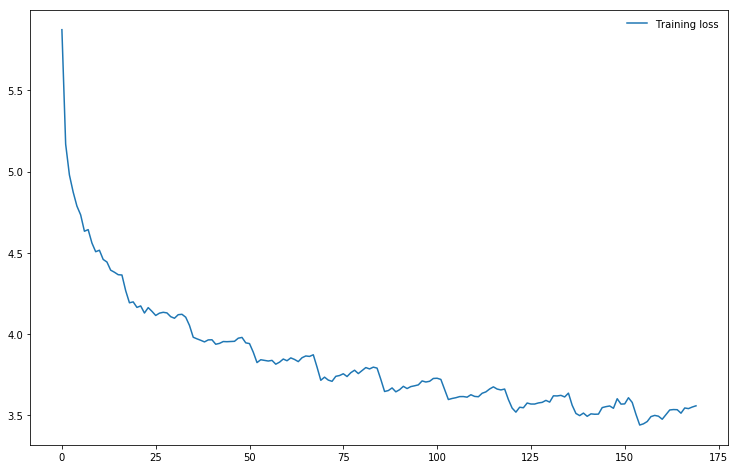

In [40]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [12.5, 8]

plt.plot(train_losses, label="Training loss")
plt.legend(frameon=False)
plt.show()

## We achieved a loss of 3.440298  during the 10th epoch
- **Saved as rnn_best_loss_10**

## Adjust learning rate and train for a further 5 epochs 

In [41]:
trained_rnn = helper.load_model('./save/trained_rnn')

num_epochs = 5
learning_rate = 0.00005
parameters = filter(lambda p: p.requires_grad, trained_rnn.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

with active_session():
    trained_rnn_1 = train_rnn(trained_rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

    # saving the trained model
    helper.save_model('./save/trained_rnn', trained_rnn)
    print('Model Trained and Saved')

Training for 5 epoch(s)...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Epoch:    1/5     Loss: 3.414035885810852

Validation loss decreased (3.440298 --> 3.414036  Saving model as rnn_best_loss_1...)


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    1/5     Loss: 3.4049536957740782

Validation loss decreased (3.414036 --> 3.404954  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 3.411756290435791

Epoch:    1/5     Loss: 3.4223030033111574

Epoch:    1/5     Loss: 3.4142546615600584

Epoch:    1/5     Loss: 3.4283221945762636

Epoch:    1/5     Loss: 3.4224466042518618

Epoch:    1/5     Loss: 3.4300840978622436

Epoch:    1/5     Loss: 3.4384765949249267

Epoch:    1/5     Loss: 3.4357523846626283

Epoch:    1/5     Loss: 3.4481378812789916

Epoch:    1/5     Loss: 3.440505241394043

Epoch:    1/5     Loss: 3.4402985076904296

Epoch:    1/5     Loss: 3.430366267681122

Epoch:    1/5     Loss: 3.4402459936141967

Epoch:    1/5     Loss: 3.4541838235855105

Epoch:    1/5     Loss: 3.4249784507751464

Epoch:    2/5     Loss: 3.4352436143673364

Epoch:    2/5     Loss: 3.4089230222702027

Epoch:    2/5     Loss: 3.4075649914741515

Epoch:    2/5     Loss: 3.388778645992279

Validation loss decreased (3.404954 --

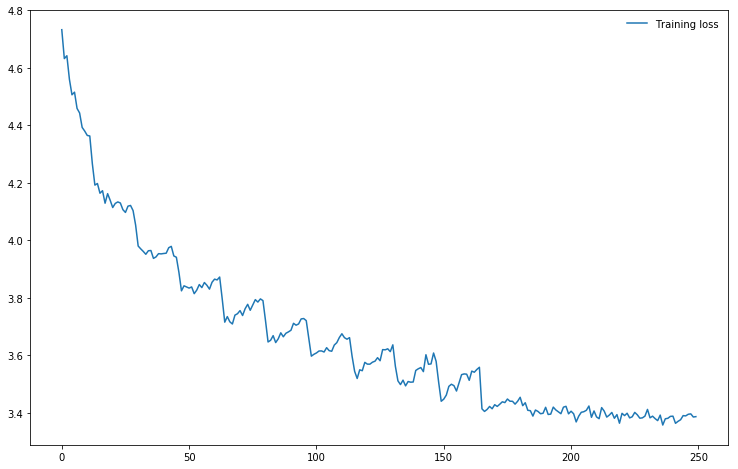

In [42]:
plt.rcParams['figure.figsize'] = [12.5, 8]
plt.plot(train_losses[5:], label="Training loss")
plt.legend(frameon=False)
plt.show()

### The best loss, at 3.357648, is saved as rnn_best_loss_5, which is actually from epoch 15...

In [43]:
os.rename('rnn_best_loss_5.pt', 'rnn_best_loss_15.pt')

### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

### Answer:
Various parameters were extensively tested, using my PC which has a GTX 1080 card. 

1. **Sequence length:** I tested up to 20, at which point the model didn't train at all well, and at 15, 10, 8, and 5. The longer sequence lengths sometimes delivered interestingly longer text passages in the script output, but lower settings produced reasonably consistent, somewhat sensible phrases that looked like a conversation. Smaller sequence lengths were favourable to model convergence but needed to be balanced with the usefulness of the output. A sequence length of 8 was optimal, which was evaluated after testing with 10 for some time and gave me just as good output but converged more reliably.
2. **Batch size:** This was a limiting factor, if I tried a larger batch size of around 200 then my PC often just reset without warning. After some testing it was found that a size of 100 gave me good enough results without harware crashes.
3. **Number of epochs:** I needed around 10 epochs to get down to a 3.5 loss. However, due to the sawtooth pattern on the loss values, where the best loss occurred earlier in an epoch, I needed to train a further 5 epochs with a lower learning rate to get a consistent loss under 3.5.
4. **Learning rate:** A setting of 0.005 was best in the first phase of training, but by 10 epochs a lower rate of 0.00005 managed to push the model to below a 3.5 loss more efficiently, if I left the rate at 0.0005 then it would not get to the better loss.
5. **Vocabulary size:** This was set to the length of the vocabulary by measuring the vocab_to_int array. Note that this already includes the additional SPECIAL_WORDS.
6. **Output size:** I set this to the same as the vocabulary size, but this was after seeking advice and I am not sure that this is optimal. Do we really need to have the same output length as our input or would we benefit from trimming it?
7. **Embedding Dimension:** After experimenting with 400 and 300, I switched to using pre-trained GloVe.6B.300d embeddings to initialise my model, so settled on 300 to align with that. I found that using the pre-trained embeddings made a considerable improvement to the output.
8. **Hidden Dimension:** I experimented a lot with this, but found that at 300 I had a manageable training, going higher seemed to result in a fragility in my environment like increasing batch size did, as well as being slower and more difficult to converge.
9. **Number of layers:** I chose 3 as that was the recommended number in any literature I consulted around this kind of task.
10. **Show stats every n batches:** I picked 500 as that was a good interval for testing, reporting and saving average losses. 

### Further points:
- The [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) glove.6B.300d word-embeddings were useful, the model began to converge more quickly and the output seemed more coherent.
- I needed to alter some of the "DON'T MODIFY" cells to work with this, for instance to use active_session, to save intermediate results and an array of training losses, and to test the use of some of my model parameters. 
- My model can be configured as a GRU, which is suggested as an option by the notebook, but tests.test_rnn would not pass a model configured as a GRU - it complained about the hidden state size being incorrect - it expects init_hidden to return two components (hidden and cell state) but there can only be one component for a GRU as it cannot utilize cell state.  
e.g. "`AssertionError: Wrong hidden state size. Expected type (2, 50, 10). Got type torch.Size([50, 10])`".   
However, I did evaluate the GRU but found it didn't converge any more efficiently than the LSTM or yield a better output.

---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnn')

## Or, load checkpoint with best loss....

In [45]:
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/rnn_best_loss_15')

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [47]:
import warnings
warnings.simplefilter('ignore') # "error", "ignore", "always", "default", "module", or "once"

In [48]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

jerry:.........." i mean," hey, what are we doing?

george: well, i guess i'm not really interested.

elaine: you know, i think i can have some kind of thinking.

jerry: what are you doing here?

kramer: yeah...

george: what are you doing?

elaine: well, it doesn't matter.

jerry:(looking at the counter) oh, i know. i just don't have a little more... you know, i don't think so.

jerry:(to george) what about your face?

george: no, no, i just don't. i mean, i don't know, i can't.

elaine: i think you should be a little hungry.

kramer: oh, well, i was a little nervous, i just don't have to do this.

george: oh, yeah, yeah. yeah i gotta go. i can't do this. it's all right... i don't know why i'm gonna do.(hangs up)

george:(still looking up) hey, what are you talking about?

jerry: well, i think we have a little problem.

elaine:(to jerry) i know, i don't have any chance.

elaine:(looking at the window) i can't believe it. you know what i mean?

kramer: oh yeah, well, you know, the only

In [49]:
# save script to a text file
f =  open("generated_script_jerry.txt","w")
f.write(generated_script)
f.close()

In [50]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'elaine' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

elaine:....."(kramer enters. jerry is not looking at him...

kramer: yeah, i know what you do. i don't know what it is.

elaine: i know, but i don't have any trouble, i can't.

jerry: well, what is it?

george: no no, i don't know. i just had to do it.

jerry:(to jerry) you know what?

george: well, it's a big mistake.

george: i thought you were gonna get it.

george:(to himself) i don't have a job.

jerry: i think i can have sex with him.

george: oh, yeah. i don't know if you want.

george: well, i guess we were talking about this guy.

george: oh, i know, but i don't think so.

elaine:(looking at the bathroom) i was just a one of your own life.

elaine:(pointing) well, i guess i have a very good idea. you know, you know, i know, i think you should get a lot of paper out of here.

jerry: i don't know, i don't know what you want to be.

jerry: well, you know, i'm gonna have to do that.

kramer: oh, yeah.

george: oh, i got news.(he turns out)

jerry: you think you can do that?

georg

In [51]:
# save script to a text file
f =  open("generated_script_elaine.txt","w")
f.write(generated_script)
f.close()

In [52]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'kramer' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

kramer: models.

kramer:(looking at his watch) oh, i don't know how to get.

elaine: oh, i can't believe this is a joke.(george enters and takes a bite of the sink) oh, i forgot to go back to the bathroom.

jerry: what?

jerry: well, i guess i could have a little more of the most thing.

jerry: well, you don't have anything. i don't know what it is. i don't know why you can do that. you know, i don't know.

jerry: i know, maybe he wants me to get a bite.

elaine: what do you want to do?

jerry: no.

elaine: well...(jerry hangs up the phone)

jerry:(looking in her watch) hey, what do you think?

george: you got a big deal.

george:(to kramer) hey, what are you talking about?

george: i don't know.

elaine: i think we could get it.

kramer:(laughing, he is noticing)

jerry: i can't believe i was just doing.

elaine: oh my god.

george:(to jerry) what about the car?

george: yeah, well, you know, i know, you know, we were just going to get out.

george: what?

jerry:(pointing out) hey. he

In [53]:
# save script to a text file
f =  open("generated_script_kramer.txt","w")
f.write(generated_script)
f.close()

In [54]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'george' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

george:

elaine: oh, hi, mr. pitt, what are we gonna do? you wanna go out to the hospital.

jerry: i can't.

kramer:(to the waitress) hey george, i'm going to have some problems.

george: well, you should see him.

george: oh my god, i got a little bit.

kramer: hey! hey, wait a second!

jerry: you think you want to go to the bathroom.(george enters. george is sitting in his room and closes her hand)

elaine:(to jerry, to the other side) you know, you know, i don't want any money. i can't take it anymore and i have to get it.

george: i don't know, but you were gonna do it. you know. i think i can do a lot of a problem. i mean...

elaine:(to george) hey!

elaine: hey, hey, you guys want to see that.

jerry: oh.

jerry: hey, you know i got this straight in the building?(jerry enters.)

jerry:(to the phone) yeah, you don't understand what to do.

jerry: you know?

jerry: no, no.

jerry: i don't have a good idea with you. i just don't think you could do it.

george: oh, you know, it's a l

In [55]:
# save script to a text file
f =  open("generated_script_george.txt","w")
f.write(generated_script)
f.close()

In [56]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'ronnie' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


ronnie:.

george:(to the waitress) well, you don't understand why i think it would have done.

george:(to elaine) i know.

george: you know what?

george: you got a date with the foreman and i don't know what it is.

jerry: i don't know, i was in there.

jerry: oh yeah? well, what do you want?

george: i don't like you.

kramer: well, i was just curious, but i was in a bit of it.

george:(to george) hey, how ya doin'?

kramer: oh, no, no, no, no, no, no. i'm not gonna get a cab.

kramer: well, what are we talking about?

newman: yeah, i got some new food for you.

jerry: what about the car?

george:(smiling) oh, you know this is my business, and i don't even like the money. i mean, you know, it's not a lot of thing.

jerry:(to jerry) you know, i just wanted to see you.(jerry enters.)

jerry:(to kramer, excited, he turns to the couch, she puts the pen on her mouth)

elaine: you don't understand.

jerry:(looking down at the counter)

george: what is that?

kramer: yeah.

george: what do 

# My favourite line:

## "(george enters and takes a bite of the sink)"

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [57]:
# save script to a text file
f =  open("generated_script.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.

---

# Extra Procedures

<a id='dataExplore'></a>

## Explore data in more depth - Check data ranges, and eliminate unuseful words 
- requires dict/wordsEn.txt and dict/words.txt
- looking for lines where the text is very brief or not recognizably English

In [58]:
english_words = {}
with open("dict/wordsEn.txt") as word_file:
    english_words = set(word.strip().lower() for word in word_file if len(word) > 0)
with open("dict/words.txt") as word_file:
    english_words = set(word.strip().lower() for word in word_file if len(word) > 0)  
english_words.add("o.k.")

In [59]:
def is_english_word(word):
    return 1 if word.lower() in english_words else 0

In [60]:
import pandas as pd
import re as re
import operator
from collections import Counter

def uniqueratio(wcount, uwcount):
    if uwcount == 0:
        retval = 1.
    else:
        retval = wcount / uwcount
    return retval

def textDF (text):
    # Data and target as a data frame, with word count attributes
    DF = pd.DataFrame(text, columns = ["Text"])
    DF['Character'] = DF.Text.apply(lambda x: x[: x.find(':')])
    DF['Stripped'] = DF.Text.apply(lambda x: re.sub (r'([^a-zA-Z\s]+?)', '', x))
    DF['DataLength'] = DF.Stripped.apply(len)
    DF['WordCount'] = DF.Stripped.apply(lambda x: re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x)).apply(len)
    DF['EnglishPerc'] = DF.Stripped.apply(lambda x: [is_english_word(w) for w in x]).apply(sum) / DF.WordCount
    DF['WordsCounts'] = DF.Stripped.apply(lambda x: Counter(filter(None, re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x))))    
    DF['UniqueWords'] = DF['WordsCounts'].apply(len)
    DF['UniqueRatio'] = DF.apply(lambda x: uniqueratio(x['WordCount'], x['UniqueWords']), axis =1) 
    ## DF['NoPunctuation'] = DF.Text.apply(lambda x: ''.join(e for e in x if e.isalnum()))
    DF['DataIndex'] = DF.index
    DF = DF[['Text', 'Character', 'DataLength', 'WordCount', 'UniqueWords', 
             'Stripped', 'UniqueRatio', 'EnglishPerc', 'DataIndex', 'WordsCounts' ]]
    
    return DF

In [61]:
textSplit = text.split("\n\n")

In [62]:
Text_df = textDF(textSplit)

In [63]:
pd.set_option('display.max_colwidth', 80)
Text_df.head(5)

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc,DataIndex,WordsCounts
0,"jerry: do you know what this is all about? do you know, why were here? to be...",jerry,929,192,97,jerry do you know what this is all about do you know why were here to be out...,1.979381,3.843750,0,"{'jerry': 1, 'do': 4, 'you': 16, 'know': 3, 'what': 3, 'this': 3, 'is': 6, '..."
1,"jerry: (pointing at georges shirt) see, to me, that button is in the worst p...",jerry,220,43,33,jerry pointing at georges shirt see to me that button is in the worst possib...,1.303030,4.139535,1,"{'jerry': 1, 'pointing': 1, 'at': 2, 'georges': 1, 'shirt': 2, 'see': 1, 'to..."
2,george: are you through?,george,23,5,4,george are you through,1.250000,3.800000,2,"{'george': 1, 'are': 1, 'you': 1, 'through': 1}"
3,"jerry: you do of course try on, when you buy?",jerry,43,11,9,jerry you do of course try on when you buy,1.222222,3.000000,3,"{'jerry': 1, 'you': 2, 'do': 1, 'of': 1, 'course': 1, 'try': 1, 'on': 1, 'wh..."
4,"george: yes, it was purple, i liked it, i dont actually recall considering t...",george,83,16,13,george yes it was purple i liked it i dont actually recall considering the b...,1.230769,4.250000,4,"{'george': 1, 'yes': 1, 'it': 2, 'was': 1, 'purple': 1, 'i': 2, 'liked': 1, ..."


### Get unique names of Seinfield characters and feed into english words dict, then re-run dataframe...
- Wanting to identify rows with not much recognized English, but need to ensure the majority of the characters in the show are counted as English words.

In [64]:
charactersSet = set(list(Text_df.Character))
characters_df = pd.DataFrame(list(charactersSet), columns = ["Character"])

In [65]:
characters_df[characters_df.Character.str.len() < 30][:10]

,Character
0,
1,greg (looks at his watch)
2,kramer & george
3,boyfriend
4,workers (singing)
5,jim
6,sasha
7,kramer (panting)
8,man in shower
9,jerry & tia


### Just use a name if its longer than zero and <= than 20

In [66]:
for character in characters_df.values:
    charac = character[0]
    bracketpos = charac.find('(')
    if bracketpos < 0:
        bracketpos = charac.find('[')
    if bracketpos >= 0:
        charac = charac[:bracketpos]
    if (len(charac) > 0) & (len(charac) <= 20):
        print(charac)
        english_words.add(charac)
        english_words.add(charac+":")

**Sample output:**
```
greg 
kramer & george
boyfriend
workers 
jim
sasha
kramer 
man in shower
jerry & tia
ronnie 
jerry 
kramer 
helen & morty
fred 
spike
pat
old man #3
winona 
tough guy 
mailman
elaine 
jerry's penis
mr tanaka
opening monolog
building c
kramer 
julio
cheryl
wendy
tall girl
elaine 
```

In [67]:
is_english_word("subway announcement")

1

### Re-create dataframe after adding character names to the english words dictionary...

In [68]:
Text_df = textDF(textSplit)

In [69]:
pd.set_option('display.max_colwidth', -1)

In [70]:
Text_df.loc[:20, :"Stripped"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped
0,"jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, its my feeling, youve gotta go.",jerry,929,192,97,jerry do you know what this is all about do you know why were here to be out this is outand out is one of the single most enjoyable experiences of life peopledid you ever hear people talking about we should go out this is what theyre talking aboutthis whole thing were all out now no one is home not one person here is home were all out there are people trying to find us they dont know where we are on an imaginary phone did you ring i cant find him where did he go he didnt tell me where he was going he must have gone out you wanna go out you get ready you pick out the clothes right you take the shower you get all ready get the cash get your friends the car the spot the reservationthen youre standing around what do you do you go we gotta be getting back once youre out you wanna get back you wanna go to sleep you wanna get up you wanna go out again tomorrow right where ever you are in life its my feeling youve gotta go
1,"jerry: (pointing at georges shirt) see, to me, that button is in the worst possible spot. the second button literally makes or breaks the shirt, look at it. its too high! its in no-mans-land. you look like you live with your mother.",jerry,220,43,33,jerry pointing at georges shirt see to me that button is in the worst possible spot the second button literally makes or breaks the shirt look at it its too high its in nomansland you look like you live with your mother
2,george: are you through?,george,23,5,4,george are you through
3,"jerry: you do of course try on, when you buy?",jerry,43,11,9,jerry you do of course try on when you buy
4,"george: yes, it was purple, i liked it, i dont actually recall considering the buttons.",george,83,16,13,george yes it was purple i liked it i dont actually recall considering the buttons
5,"jerry: oh, you dont recall?",jerry,25,6,5,jerry oh you dont recall
6,"george: (on an imaginary microphone) uh, no, not at this time.",george,57,12,11,george on an imaginary microphone uh no not at this time
7,"jerry: well, senator, id just like to know, what you knew and when you knew it.",jerry,75,17,14,jerry well senator id just like to know what you knew and when you knew it
8,claire: mr. seinfeld. mr. costanza.,claire,31,6,4,claire mr seinfeld mr costanza
9,"george: are, are you sure this is decaf? wheres the orange indicator?",george,66,13,11,george are are you sure this is decaf wheres the orange indicator


### Sentences with a low percentage of plain English words or low word count may be discarded...

In [71]:
Text_df[(Text_df.EnglishPerc < 1.66) | (Text_df.WordCount < 3) | (Text_df.UniqueWords < 2)].loc[:, :"EnglishPerc"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
428,vanessa: vanessa.,vanessa,16,3,1,vanessa vanessa,3.000000,4.666667
488,helen: ...30...31...,helen,7,2,1,helen,2.000000,2.500000
490,helen: ...32...,helen,7,2,1,helen,2.000000,2.500000
4306,ed: 915?,ed,4,2,1,ed,2.000000,1.000000
4717,published: 1941,published,11,2,1,published,2.000000,4.500000
4803,george: george,george,14,3,1,george george,3.000000,4.000000
5092,morty: 19.45$ ?,morty,8,2,1,morty,2.000000,2.500000
6109,jerry: jerry.,jerry,12,3,1,jerry jerry,3.000000,3.333333
6220,george: 145!,george,8,2,1,george,2.000000,3.000000
6397,george: 85!,george,8,2,1,george,2.000000,3.000000


### Preserve the row indexes as a series so they can be identified and removed later...

In [72]:
badRows = pd.Series(Text_df[(Text_df.EnglishPerc < 1.66) | (Text_df.WordCount < 3) | (Text_df.UniqueWords < 2)].index)

In [73]:
badRows[:5]

0    428 
1    488 
2    490 
3    4306
4    4717
dtype: int64

In [74]:
Text_df[Text_df.index.isin(badRows)].loc[485:491, :"EnglishPerc"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
488,helen: ...30...31...,helen,7,2,1,helen,2.0,2.5
490,helen: ...32...,helen,7,2,1,helen,2.0,2.5


In [75]:
Text_df[~Text_df.index.isin(badRows)].loc[485:491, :"EnglishPerc"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
485,"jerry: yeah, but now im nervous.",jerry,30,7,6,jerry yeah but now im nervous,1.166667,3.428571
486,"helen: oh, stop it.",helen,17,5,4,helen oh stop it,1.250000,2.600000
487,jerry: quone?,jerry,12,3,2,jerry quone,1.500000,3.333333
489,"jerry: quone? no, im afraid that im going to have to challenge that.",jerry,65,14,10,jerry quone no im afraid that im going to have to challenge that,1.400000,3.714286
491,"kramer: no, you dont have to challenge that. thats a word. thats a definite word.",kramer,77,16,12,kramer no you dont have to challenge that thats a word thats a definite word,1.333333,3.875000


### Passages with a high word count are more than OK, and can be appreciated!

In [76]:
pd.set_option('display.max_colwidth', -1)
Text_df[Text_df.WordCount > 250].loc[:, :"UniqueWords"]

,Text,Character,DataLength,WordCount,UniqueWords
148,"jerry: the dating world is not a fun world...its a pressure world, its a world of tension, its a world of pain...and you know, if a woman comes over to my house, i gotta get that bathroom ready, cause she needs things. women need equipment. i dont know what they need. i know i dont have it, i know that- you know what they need, women seem to need a lot of cotton-balls. this is the one im- always has been one of the amazing things to me...i have no cotton-balls, were all human beings, what is the story? ive never had one...i never bought one, i never needed one, ive never been in a situation, when i thought to myself i could use a cotton-ball right now. i can certainly get out of this mess. women need them and they dont need one or two, they need thousands of them, they need bags, theyre like peat moss bags, have you ever seen these giant bags? theyre huge and two days later, theyre out, theyre gone, the, the bag is empty, where are the cotton-balls, ladies? what are you doin with them? the only time i ever see em is in the bottom of your little waste basket, theres two or three, that look like theyve been through some horrible experience... tortured, interrogated, i dont know what happened to them. i once went out with a girl who left a little zip-lock-baggy of cotton-balls over at my house. i dont know what to do with them, i took them out, i put them on my kitchen floor like little tumbleweeds. i thought maybe the cockroaches would see it, figure this is a dead town. lets move on. the dating world is a world of pressure. lets face it a date is a job interview that lasts all night. the only difference between a date and a job interview is not many job interviews is there a chance youll end up naked at the end of it. you know? well, bill, the boss thinks youre the man for the position, why dont you strip down and meet some of the people youll be working with?",jerry,1815,365,176
210,"jerry: i swear, i have absolutely no idea what women are thinking. i dont get it, okay? i, i, i admit, i, im not getting the signals. i am not getting it! women, theyre so subtle, their little...everything they do is subtle. men are not subtle, we are obvious. women know what men want, men know what men want, what do we want? we want women, thats it! its the only thing we know for sure, it really is. we want women. how do we get them? oh, we dont know bout that, we dont know. the next step after that we have no idea. this is why you see men honking car-horns, yelling from construction sites. these are the best ideas weve had so far. the car-horn honk. have you seen men doing this? what is this? the man is in the car, the woman walks by the front of the car, he honks. hey! this man is out of ideas. how does it...? i dont think she likes me. the amazing thing is, that we still get women, dont we? men, i mean, men are with women. you see men with women. how are men getting women, many people wonder. let me tell you a little bit about our organization. wherever women are, we have a man working on the situation right now. now, he may not be our best man, okay, we have a lot of areas to cover, but someone from our staff is on the scene. thats why, i think, men get frustrated, when we see women reading articles, like where to meet men? were here, we are everywhere. were honking our horns to serve you better.",jerry,1350,283,131
1425,"jerry: the waiting room. i hate when they make you wait in the room. cause it says waiting room. theres no chance of not waiting. cause they call it the waiting room, theyre gonna use it. theyve got it. its all set up for you to wait. and you sit there, you know, and youve got your little magazine. you pretend youre reading it, but youre really looking at the other people. you know, youre thinking about about them. things like, i wonder what hes got. as soon as she goes, im getting her magazine. and then, they finally call you and its a very exciting moment. they finally 

In [77]:
pd.set_option('display.max_colwidth', 80)

In [78]:
DataLengths = Text_df.DataLength

In [79]:
DataLengths.mean(), DataLengths.std(), DataLengths.min(), DataLengths.max()

(56.675723675778606, 59.55366458532647, 0, 1815)

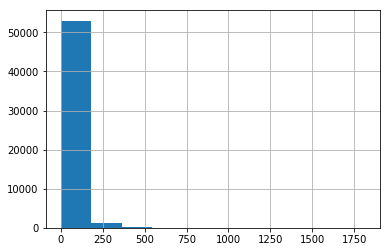

In [80]:
DataLengths.hist()

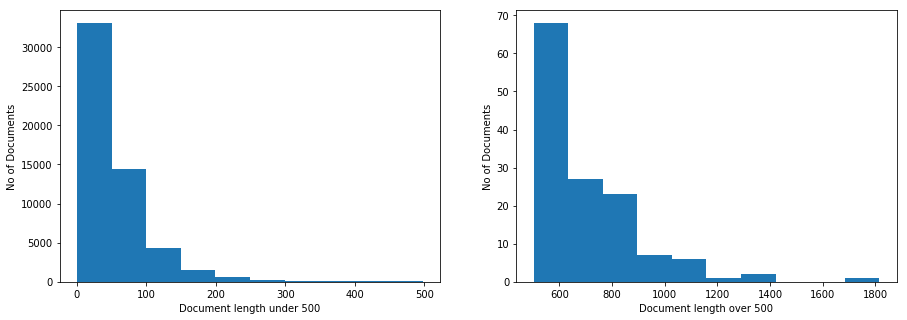

In [81]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(DataLengths[DataLengths <= 500]);
ax1.set_xlabel('Document length under 500')
ax1.set_ylabel('No of Documents')
ax2.hist(DataLengths[DataLengths > 500]);
ax2.set_xlabel('Document length over 500')
ax2.set_ylabel('No of Documents');

In [82]:
WordCounts = Text_df.WordCount

In [83]:
WordCounts.mean(), WordCounts.std(), WordCounts.min(), WordCounts.max()

(12.027097790065364, 11.817984106386616, 1, 365)

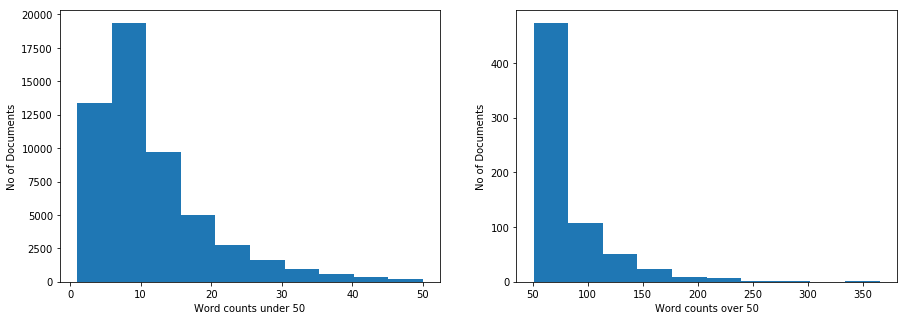

In [84]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(WordCounts[WordCounts <= 50]);
ax1.set_xlabel('Word counts under 50')
ax1.set_ylabel('No of Documents')
ax2.hist(WordCounts[WordCounts > 50]);
ax2.set_xlabel('Word counts over 50')
ax2.set_ylabel('No of Documents');

In [85]:
pd.set_option('display.max_colwidth', 80)

In [86]:
WordCountsClean = Text_df[~Text_df.index.isin(badRows)].WordCount

In [87]:
WordCountsClean.mean(), WordCountsClean.std(), WordCountsClean.min(), WordCountsClean.max()

(12.036820497782339, 11.819940124318654, 3, 365)

<a id='dataRefine'></a>

## Export as an alternative refined text file without the very short entries

In [88]:
import os
output_file = os.path.join('./data/Seinfeld_Scripts_cleaned.txt')
with open(output_file, 'w') as f:
    for txt in Text_df[~Text_df.index.isin(badRows)]["Text"].tolist():
        f.write(txt + '\n\n')

### [Continue to word2vec section...](#word2vec)

### [Continue to pre-process and save section...](#preprocess_save)

## Renumber notebook cells

In [90]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>